In [1]:
import imageio
import numpy as np
import h5py
import sys
import captum
import torch
from matplotlib import pyplot as plt

In [2]:
sys.path.append('/home/temp/kunal/project/fastMRI')

In [3]:
f = h5py.File("data/singlecoil_val/file1000000.h5", 'r')
print(f.keys())
data = np.array(f['reconstruction_esc'])
print(data.shape)
#plt.imshow(data[34,:,:])
#file = sys.argv[2] # or .jpg
#imageio.imwrite(file, data)

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
(35, 320, 320)


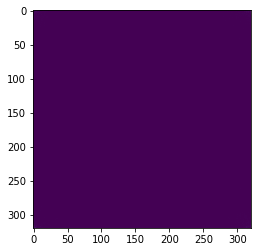

In [4]:
dats = np.array(f['kspace'])
pt = np.fft.ifft2(data)
plt.imshow(np.abs(pt[20,:,:]))

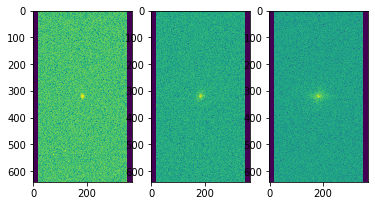

In [7]:
def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
show_slices(np.log(np.abs(data) + 1e-9),[0, 5, 10])  # This shows slices 0, 5 and 10

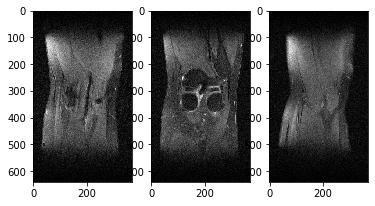

In [8]:
from data import transforms as T
slice_kspace2 = T.to_tensor(data)      # Convert from numpy array to pytorch tensor
slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = T.complex_abs(slice_image)
show_slices(slice_image_abs, [30, 26, 34], cmap='gray')

In [9]:
#load trained model here
#from captum.attr import IntegratedGradients, Saliency
from models.unet.train_unet import UnetMRIModel
model = UnetMRIModel.load_from_checkpoint('model/checkpoints/epoch=48.ckpt')
#ig = IntegratedGradients(model.unet)
for param in model.unet.parameters():
    param.requires_grad = True

In [5]:
#load trained model here
#from captum.attr import IntegratedGradients, Saliency
from models.unet.train_unet import UnetMRIModel
model = UnetMRIModel.load_from_checkpoint('model/_ckpt_epoch_57.ckpt')
#ig = IntegratedGradients(model.unet)
for param in model.unet.parameters():
    param.requires_grad = True

In [6]:
#Image and target image
from data import transforms as T
kspace = T.to_tensor(np.array(f['kspace']))
image = T.ifft2(kspace)
target = T.to_tensor(np.array(f['reconstruction_rss']))
resolution = 160
smallest_width = min(resolution, image.shape[-2])
smallest_height = min(resolution, image.shape[-3])
if target is not None:
    smallest_width = min(smallest_width, target.shape[-1])
    smallest_height = min(smallest_height, target.shape[-2])

crop_size = (smallest_height, smallest_width)
image = T.complex_center_crop(image, crop_size)
image = T.complex_abs(image)
image, mean, std = T.normalize_instance(image, eps=1e-11)
image = image.clamp(-6, 6)

target = T.center_crop(target, crop_size)
target = T.normalize(target, mean, std, eps=1e-11)
target = target.clamp(-6, 6)

In [7]:
#Model output
gs = model.unet(image.unsqueeze(1))
mean = mean.unsqueeze(0).unsqueeze(1).unsqueeze(2)
std = std.unsqueeze(0).unsqueeze(1).unsqueeze(2)
output = gs * std + mean

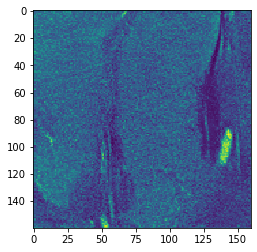

In [26]:
plt.imshow(gs.detach().cpu().numpy()[28,0,:,:])

Text(0.5, 1.0, 'Target')

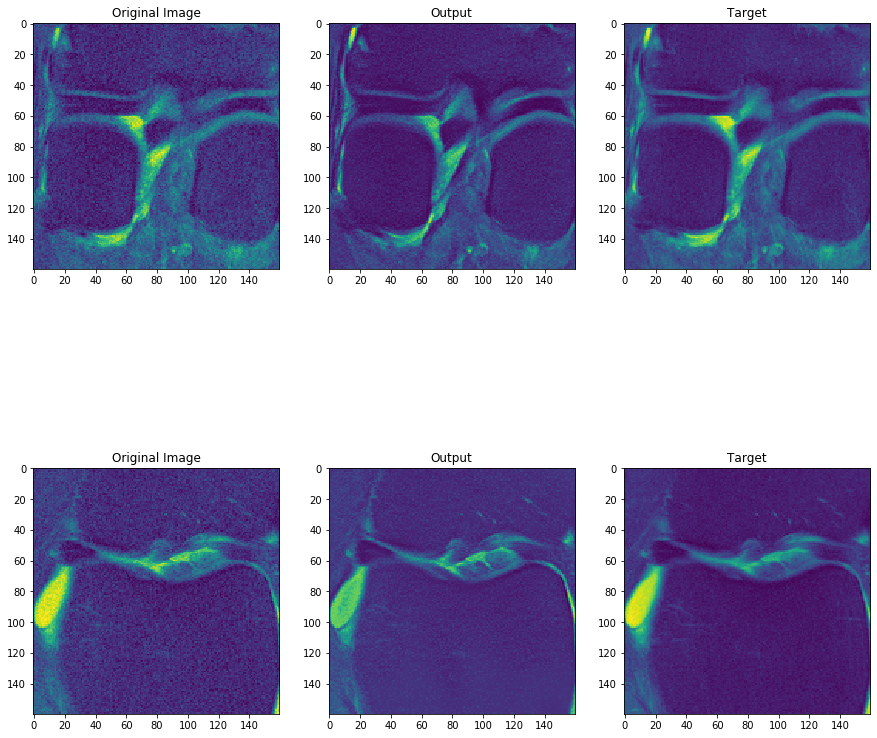

In [8]:
#Visualize image , target and output for one 2 D image
image_orig = image.detach().cpu().numpy()
saliency = output.squeeze().detach().cpu().numpy()
k = 25
k2 = 15
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
plt.imshow(image_orig[k,:,:])
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(saliency[k,:,:])
plt.title('Output')
plt.subplot(2,3,3)
#im = np.gradient(image_orig[k,:,:])
gradient_im = target.detach().cpu().numpy()
plt.imshow(gradient_im[k,:,:])
plt.title('Target')
# plt.imshow(np.gradient(image_orig[k,:,:])[0])
# plt.subplot(2,4,4)
# plt.imshow(np.gradient(image_orig[k,:,:])[1])
plt.subplot(2,3,4)
plt.imshow(image_orig[k2,:,:])
plt.title('Original Image')
plt.subplot(2,3,5)
plt.imshow(saliency[k2,:,:])
plt.title('Output')
plt.subplot(2,3,6)
gradient_im = target.detach().cpu().numpy()
plt.imshow(gradient_im[k2,:,:])
plt.title('Target')
# plt.subplot(2,4,7)
# plt.imshow(np.gradient(image_orig[k2,:,:])[0])
# plt.subplot(2,4,8)
# plt.imshow(np.gradient(image_orig[k2,:,:])[1])


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

#attributions = ig.attribute(image.unsqueeze(1), baseline.unsqueeze(1), target=target.unsqueeze(1))

Text(0.5, 1.0, 'Attention Map')

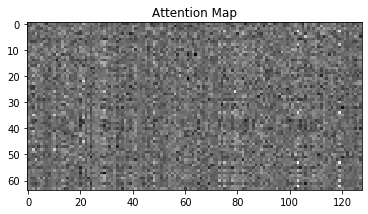

In [34]:
attention = model.unet.Att3.W_g[0].weight.data.numpy()
#model.unet.Att5
plt.imshow(attention.squeeze(), cmap = 'gray')
plt.title('Attention Map')

In [11]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    lam = 1e3 # This is the regularization parameter when you need it
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y, requires_grad=False)
    for param in model.parameters():
        param.requires_grad=False
    model.zero_grad()
    
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    #print(X.grad.nonzero().size())
    output_image = model(X_var)
    loss = F.l1_loss(output_image, y_var)
    loss.backward()
    X_gradient = X_var.grad
    saliency = torch.max(torch.abs(X_gradient),1)[0]
    
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency


In [16]:
conv_module = model.unet.up_conv[3][0].layers[4]

gradient_value = None # Stores gradient of the module you chose above during a backwards pass.
activation_value = None # Stores the activation of the module you chose above during a forwards pass.

def gradient_hook(a,b,gradient):
    global gradient_value
    gradient_value = gradient[0]
    
def activation_hook(a,b,activation):
    global activation_value
    activation_value = activation

conv_module.register_forward_hook(activation_hook)
conv_module.register_backward_hook(gradient_hook)

In [17]:
from PIL import Image
def grad_cam(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    lam = 1e3 # This is the regularization parameter when you need it
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y, requires_grad=False)
    for param in model.parameters():
        param.requires_grad=True
    model.zero_grad()
    
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    #print(X.grad.nonzero().size())
    output_image = model(X_var)
    loss = F.l1_loss(output_image, y_var)
    loss.backward()
    importance_score = torch.mean(gradient_value, [2,3])
    weighted_sum = torch.sum(activation_value.permute(2,3,0,1) * importance_score,3).permute(2,0,1)
    cam = torch.max(torch.zeros_like(gradient_value[:,0,:,:]), - weighted_sum).detach().numpy()
    cam_scaled = []
    for i in range(cam.shape[0]):
        cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X[i,0,:,:].shape)))
    cam = np.array(cam_scaled)
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam
    
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################


In [18]:
from torch.autograd import Variable
from torch.nn import functional as F
grad = grad_cam(image.unsqueeze(1), target.unsqueeze(1), model.unet)

In [12]:
from torch.autograd import Variable
from torch.nn import functional as F
saliency = compute_saliency_maps(image.unsqueeze(1), target.unsqueeze(1), model.unet)

Text(0.5, 1.0, 'Gradients')

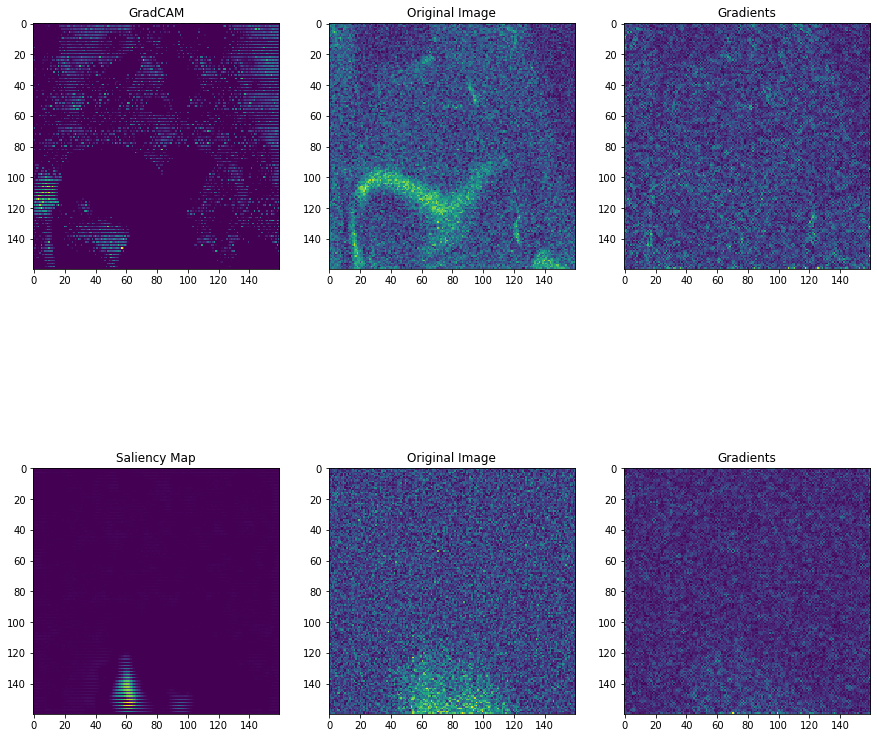

In [22]:
saliency = grad
#Visualize saliency, image , and gradients for one 2 D image
image_orig = image.detach().cpu().numpy()
#target_image = target.detach().cpu().numpy()
#target_image = np.apply_along_axis(np.gradient, 0, image_orig)
k = 10
k2 = 2
plt.figure(figsize=(15,15))
plt.subplot(2,3,1)
plt.imshow(saliency[k,:,:])
plt.title('GradCAM')
plt.subplot(2,3,2)
plt.imshow(image_orig[k,:,:])
plt.title('Original Image')
plt.subplot(2,3,3)
im = np.gradient(image_orig[k,:,:])
gradient_im = np.sqrt(im[0] ** 2 + im[1] ** 2)
plt.imshow(gradient_im)
plt.title('Gradients')
# plt.imshow(np.gradient(image_orig[k,:,:])[0])
# plt.subplot(2,4,4)
# plt.imshow(np.gradient(image_orig[k,:,:])[1])
plt.subplot(2,3,4)
plt.imshow(saliency[k2,:,:])
plt.title('Saliency Map')
plt.subplot(2,3,5)
plt.imshow(image_orig[k2,:,:])
plt.title('Original Image')
plt.subplot(2,3,6)
im = np.gradient(image_orig[k2,:,:])
gradient_im = np.sqrt(im[0] ** 2 + im[1] ** 2)
plt.imshow(gradient_im)
plt.title('Gradients')
# plt.subplot(2,4,7)
# plt.imshow(np.gradient(image_orig[k2,:,:])[0])
# plt.subplot(2,4,8)
# plt.imshow(np.gradient(image_orig[k2,:,:])[1])


Text(0.5, 1.0, 'Gradient of loss wrt images')

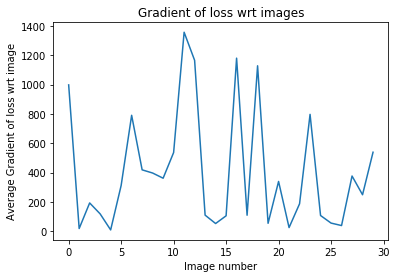

In [40]:
#contribution of each slice
sal = grad
kl = [(np.sum(np.abs(sal[i,:,:]))) for i in range(0,image_orig.shape[0])]
plt.plot( range(0,image_orig.shape[0]), kl)
plt.xlabel('Image number')
plt.ylabel('Average Gradient of loss wrt image')
plt.title('Gradient of loss wrt images')

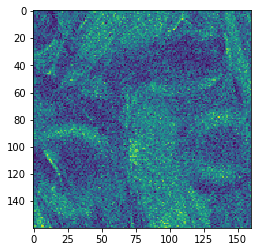

In [31]:
plt.imshow(image.detach().cpu().numpy()[25,:,:])

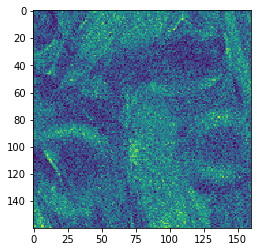

In [32]:
plt.imshow(new_img.detach().cpu().numpy()[25,0,:,:])